**Environment Setup and Data Loading**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ae72e3f753671ed028fdb7e1dac51d27119fd3130d2e26878ee2272493958ff9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("Diabetes GMM Clustering").getOrCreate()

# Load the dataset
df = spark.read.csv('/content/drive/MyDrive/DineshThapa/diabetes.csv', header=True, inferSchema=True)
df.show()

+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|              0|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|
|              0|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            

In [4]:
# Filter and select 35,000 diabetic samples
diabetic_data = df.filter(df['Diabetes_binary'] == 1).limit(35346)

# Filter and select 35,000 non-diabetic samples
non_diabetic_data = df.filter(df['Diabetes_binary'] == 0).limit(35346)

# Concatenate the two DataFrames
df = diabetic_data.union(non_diabetic_data)

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Drop rows with missing values to simplify the approach
df = df.na.drop()

# Assemble features into a single feature vector and normalize the data
assembler = VectorAssembler(
    inputCols=['HighBP', 'HighChol', 'BMI', 'Age', 'GenHlth', 'PhysHlth', 'MentHlth', 'Income'],
    outputCol='features'
)
df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [7]:
# Train the Gaussian Mixture Model
gmm = GaussianMixture(featuresCol='scaledFeatures', k=4, seed=1)
gmm_model = gmm.fit(df)

# Obtain the result of clustering
gmm_summary = gmm_model.summary
print("Cluster sizes: ", gmm_summary.clusterSizes)
df = gmm_summary.predictions

Cluster sizes:  [31322, 7470, 20341, 11559]


In [8]:
# Log-likelihood as an evaluation metric
print("Log Likelihood: ", gmm_model.summary.logLikelihood)

Log Likelihood:  -394006.3468172617


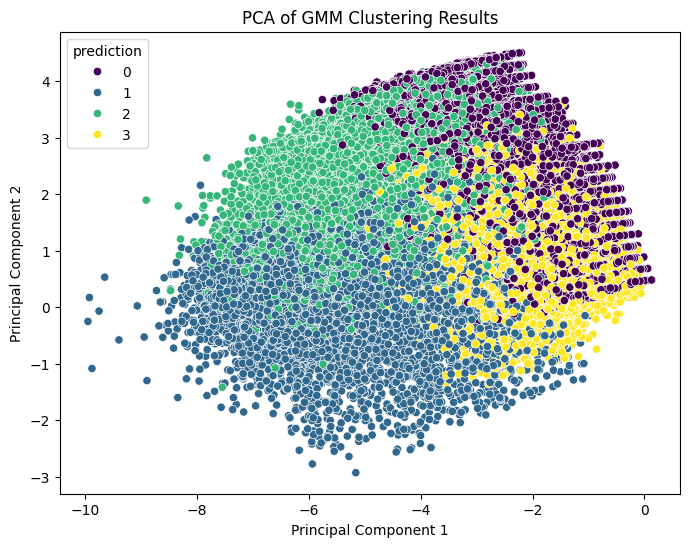

In [9]:
from pyspark.ml.feature import PCA

# Reduce dimensionality for visualization
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df)

# Convert to Pandas DataFrame for visualization
pandas_df = result.select("pcaFeatures", "prediction").toPandas()

# Extract PCA features for plotting
pandas_df['pcaFeatures'] = pandas_df['pcaFeatures'].apply(lambda x : x.toArray())
pandas_df['pc1'] = pandas_df['pcaFeatures'].apply(lambda x : x[0])
pandas_df['pc2'] = pandas_df['pcaFeatures'].apply(lambda x : x[1])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x="pc1", y="pc2", hue="prediction", data=pandas_df, palette='viridis')
plt.title('PCA of GMM Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [10]:
# Fetch cluster centers (mean of the clusters in the feature space)
cluster_centers = gmm_model.gaussiansDF.collect()
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i} center (mean): {center.mean}")

# Analyze the distribution of features within each cluster
clustered_data = df.select("features", "prediction")
cluster_summary = clustered_data.groupby("prediction").mean()

# Show cluster statistics
cluster_summary.show()


Cluster 0 center (mean): [1.0234726469903248,0.94555895684809,4.0769009534921645,3.054226996799185,2.094275808846385,0.00014656446748367448,0.00010330031083101196,2.8141957538881375]
Cluster 1 center (mean): [0.8855425959595795,1.161352967943505,4.47070995046104,2.8224313324734824,3.3527640083678008,1.9781426819118941,2.630219743590371,2.1033344208395603]
Cluster 2 center (mean): [2.013523078799383,1.3717736091457828,4.583318367364164,3.2266469570949203,3.027604954683877,1.1058640476683612,0.4314181566039409,2.354678749739346]
Cluster 3 center (mean): [0.00040393106584723495,0.6975780508121225,3.9298554856232335,2.415983602371368,2.1718326195645186,0.2926637293315908,0.35781547999689156,2.863761797432341]
+----------+---------------+
|prediction|avg(prediction)|
+----------+---------------+
|         1|            1.0|
|         3|            3.0|
|         2|            2.0|
|         0|            0.0|
+----------+---------------+

